In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from IPython.display import Video
%matplotlib widget
plt.style.use('dark_background')
from scipy import integrate as int

In [2]:
A = SlabExact(symmetric=True)

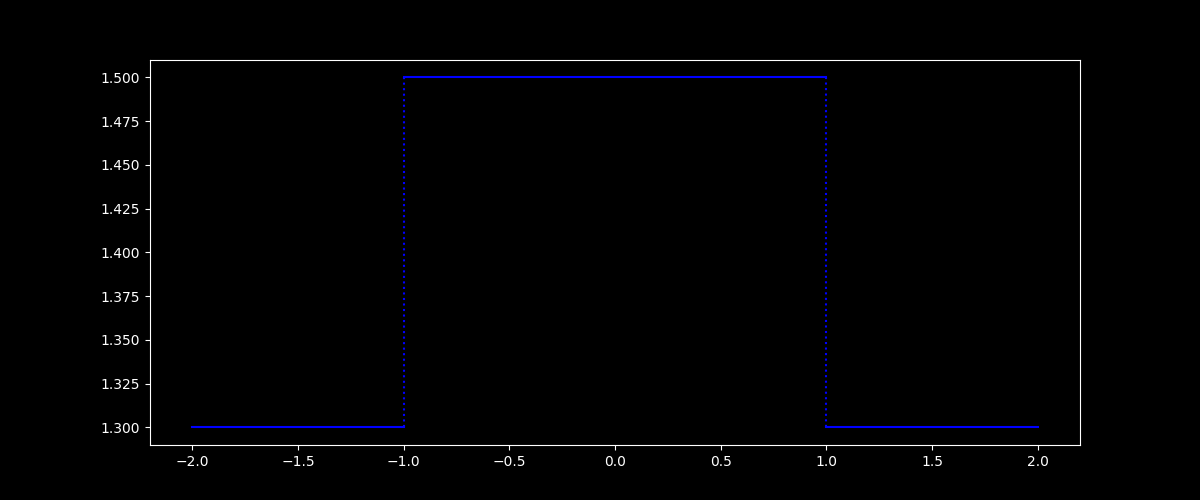

In [3]:
A.plot_refractive_index()

In [4]:
def quadratic_piecewise(x):
    conds = [(x<-.5), ((-.5<=x)*(x<=.5)), (x>.5)]
    funcs = [0, lambda x: .25-x**2, 0]
    return np.piecewise(x, conds, funcs)
    
def modified_dist(x):
    return (x-1/4) * np.exp(-(x-1/2)**2)  

def odd_modified_dist(x):
    return x * np.exp(-x**2)
    
def normal_dist(x):
    return np.exp(-x**2)


In [5]:
# Set input function

f0 = quadratic_piecewise

In [6]:
field_type = 'TE'
sign = '+1'
phase = None
exact_args = (field_type, sign, phase)


In [7]:
xs = np.linspace(-20,20,2000)

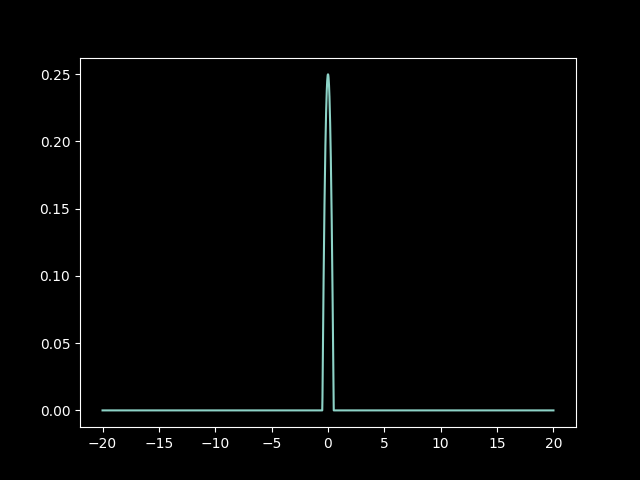

In [8]:
plt.close('all')
plt.plot(xs, f0(xs));

In [9]:
Propagator = A.propagator()

In [10]:
A.K_low

4.537856055185256

## Propagation using piecewise quadratic

In [11]:
Psci = Propagator(f0=f0, Lx=-1, Rx=1, LZ=0, RZ=120, NZ=1500, field_type=field_type, sign='+1')

In [12]:
Psci_prop = Propagator(f0=f0, Lx=-1, Rx=1, LZ=0, RZ=A.K_low, NZ=300, field_type=field_type, sign='+1')

KeyboardInterrupt: 

In [68]:
Psci_ev = Propagator(f0=f0, Lx=-1, Rx=1, LZ=A.K_low, RZ=120, NZ=1500, field_type=field_type, sign='+1')

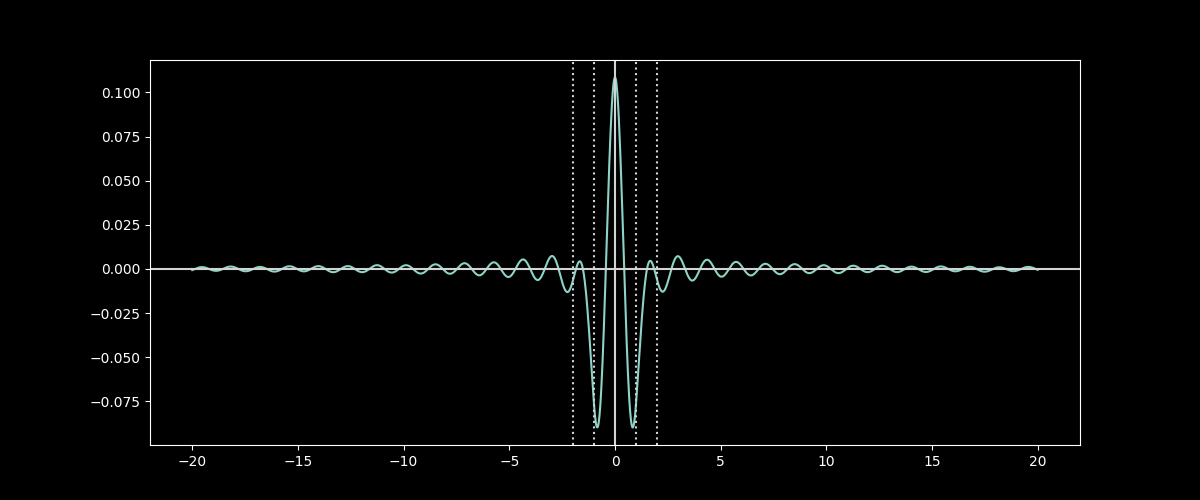

In [73]:
plt.close('all')
A.plot_field_1d(Psci_prop.z_slice_propagate, xs=xs)

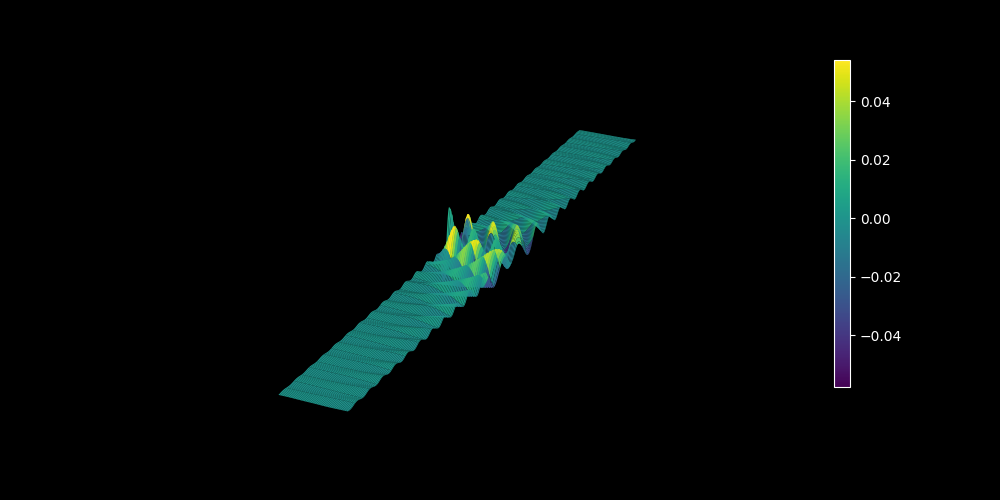

In [46]:
plt.close('all')
A.plot_field_2d(Psci_prop.propagate, xs=xs, surface=True)

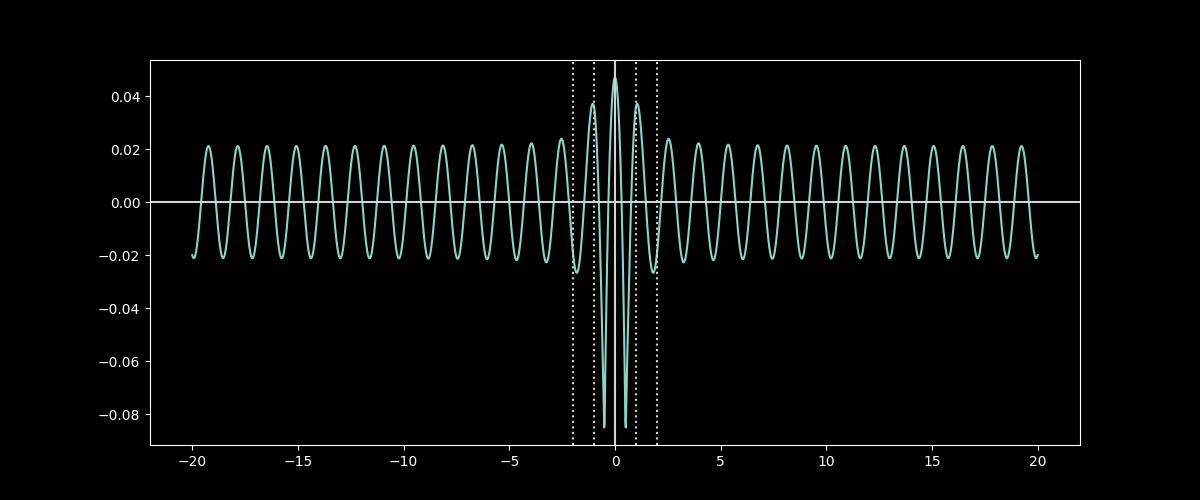

In [76]:
plt.close('all')
A.plot_field_1d(Psci_ev.z_slice_propagate, xs=xs)

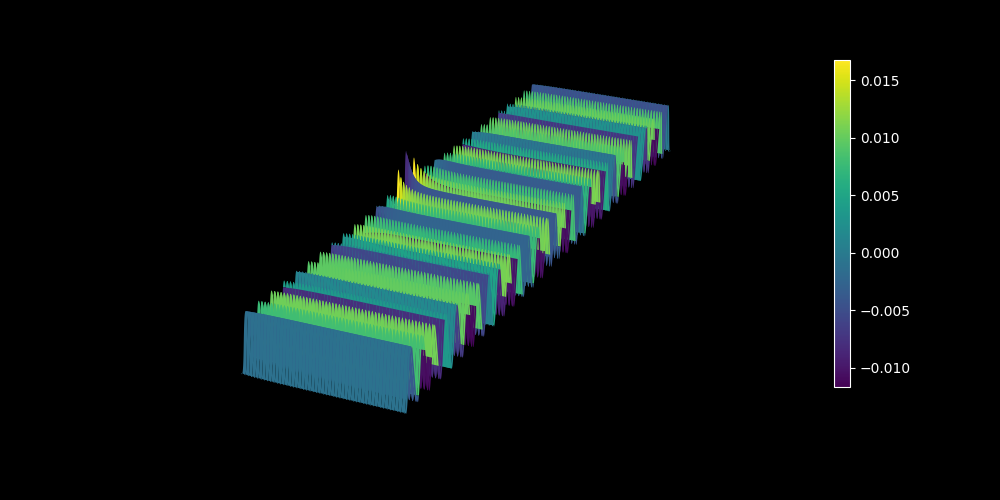

In [77]:
plt.close('all')
A.plot_field_2d(Psci_ev.propagate, xs=xs, surface=True, zmax=10)

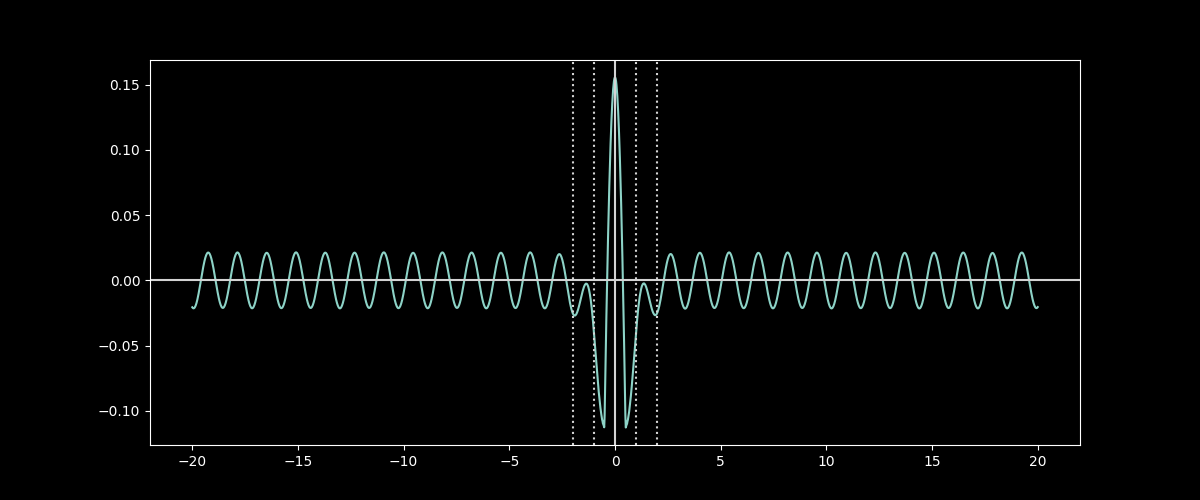

In [80]:
full = lambda x: Psci_ev.z_slice_propagate(x) + Psci_prop.z_slice_propagate(x)
A.plot_field_1d(full, xs=xs)

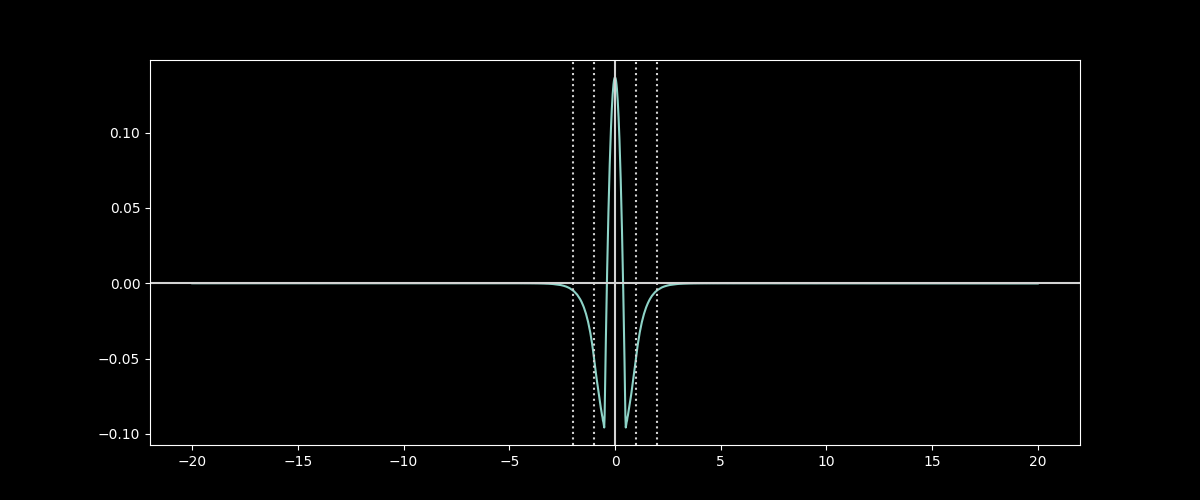

In [79]:
A.plot_field_1d(Psci.z_slice_propagate, xs=xs)

## Add in guided mode

There is one even and one odd guided mode.  Let's try and add multiples of the guided one.

In [16]:
from fiberamp.fiber.microstruct.bragg import plotlogf
from scipy.optimize import newton
from scipy.integrate import quad

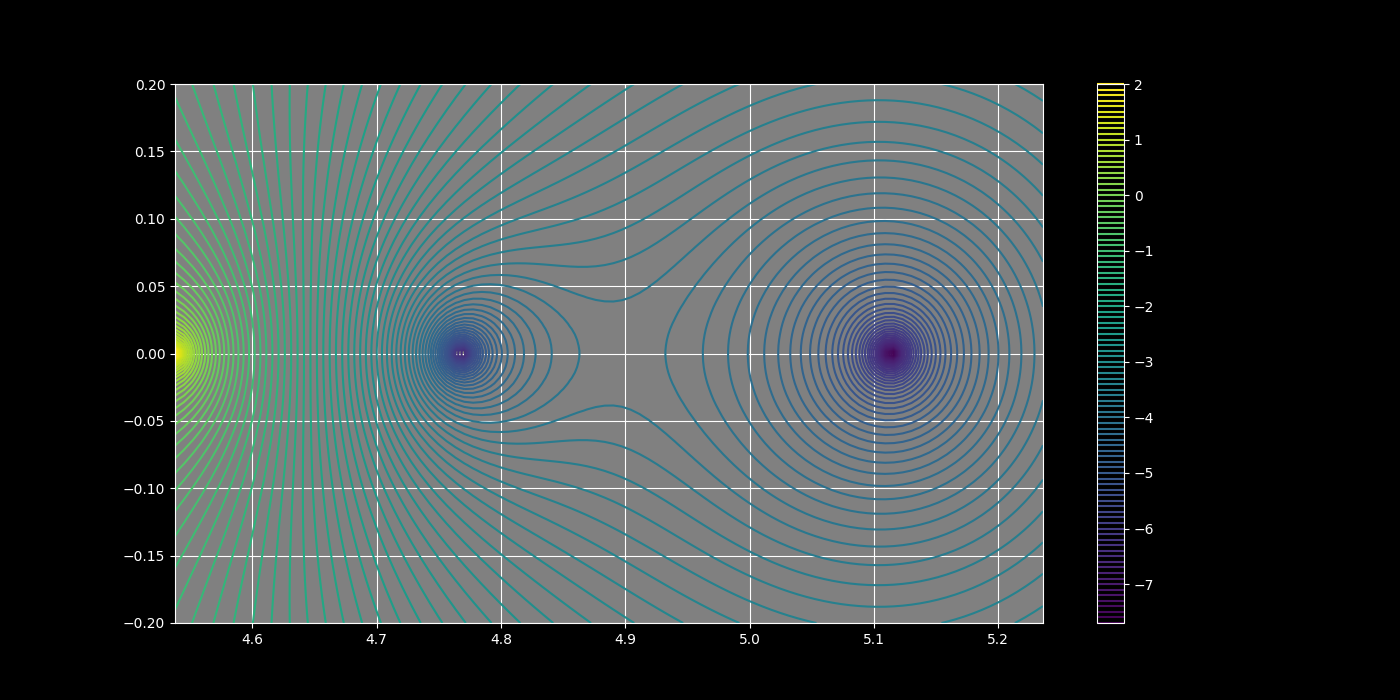

In [17]:
plotlogf(A.determinant, A.K_low, A.K_high, -.2, .2, 'TE', 'guided', iref=100, rref=100,levels=100)

In [18]:
beta3 = newton(A.determinant, 4.75, args=('TE', 'guided')).real
beta4 = newton(A.determinant, 5.1, args=('TE', 'guided')).real

Fs3 = A.fields(beta3, field_type='TE', mode_type='guided')
Fs4 = A.fields(beta4, field_type='TE', mode_type='guided')

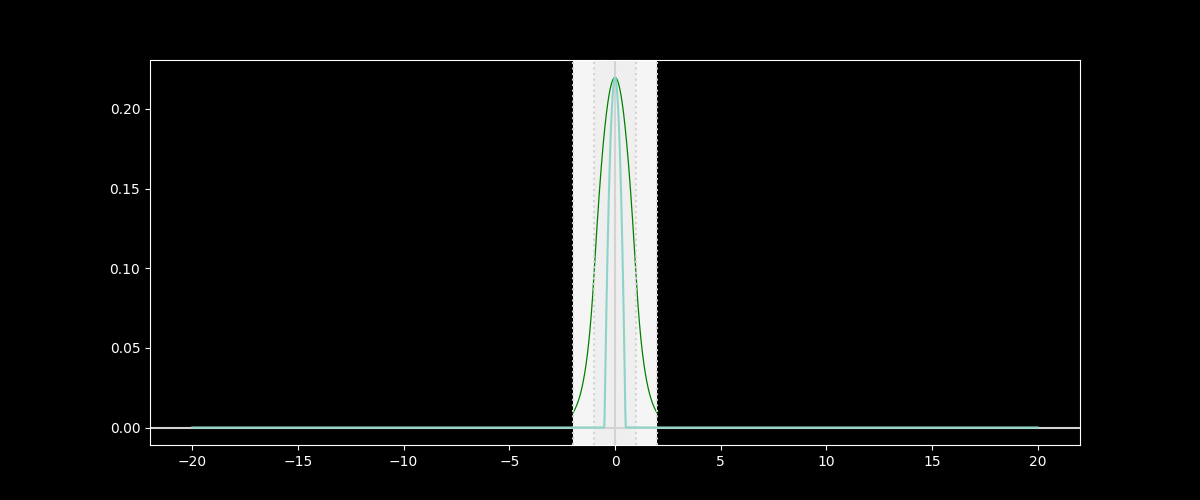

In [19]:
A.plot_field_1d(Fs4, plot_axis=True, linewidth=.9, color='g', label='TE_even', plot_regions=True, hatch=None)
ax = plt.gca()
A.add_1d_plot(ax, lambda x: 4*Fs4(0).real*f0(x), xs=xs)

In [20]:
integrand = lambda x: Fs4(x) * Fs4(x).conjugate()
cf1 = quad(integrand, -35,35, complex_func=True)[0].real

In [21]:
cf1

0.06877568014866381

In [22]:
integrand = lambda x: f0(x) * Fs4(x).conjugate()
cf2 = quad(integrand, -1,1, complex_func=True)[0].real

In [23]:
alpha = cf2/cf1
alpha

0.5158582706854129

In [26]:
full = lambda x: Psci.z_slice_propagate(x) + alpha * Fs4(x)
Full = lambda x, zs: Psci.z_propagate(x, zs=zs) + alpha * Fs4(x, zs=zs)

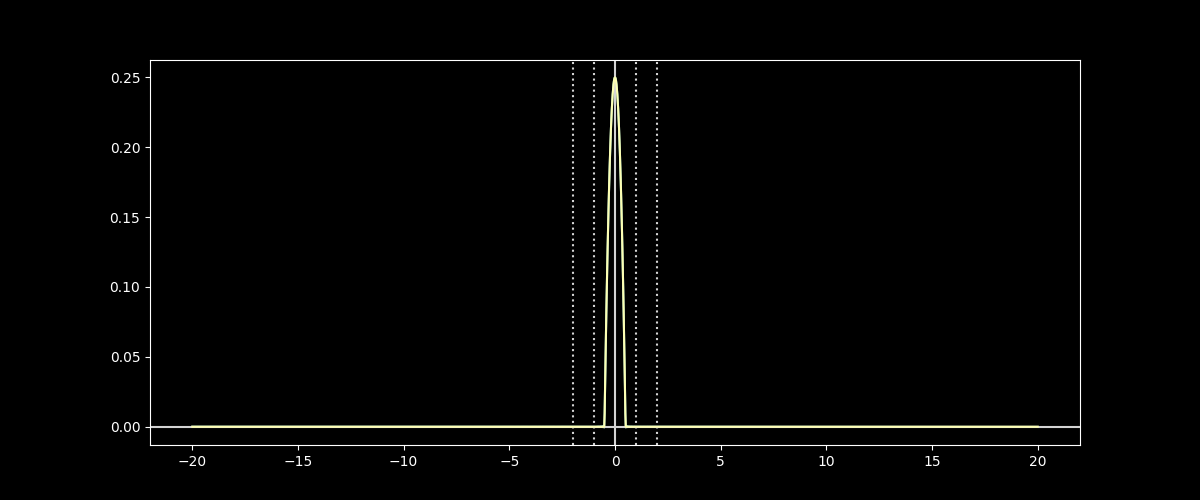

In [27]:
A.plot_field_1d(full, xs=xs, part='real')
ax = plt.gca()
A.add_1d_plot(ax, quadratic_piecewise, xs=xs)

In [31]:
ys = Psci_ev.propagate(np.linspace(-20,20,1200), zs=np.linspace(0,24,480))

In [60]:
ys.shape

(480, 1200)

In [67]:
for i in np.where(np.abs(Psci.Zs) < A.K_low)[0]:
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [17]:
Xs, Zs = np.meshgrid(np.linspace(-20,20,1200), np.linspace(0,24,480))

In [23]:
np.save('rad_field', ys)


In [24]:
np.save('radX', Xs), np.save('radZ', Zs)

(None, None)

In [20]:
XYZ = np.zeros(Xs.shape+(1,))

In [21]:
XYZ.shape

(480, 1200, 1)

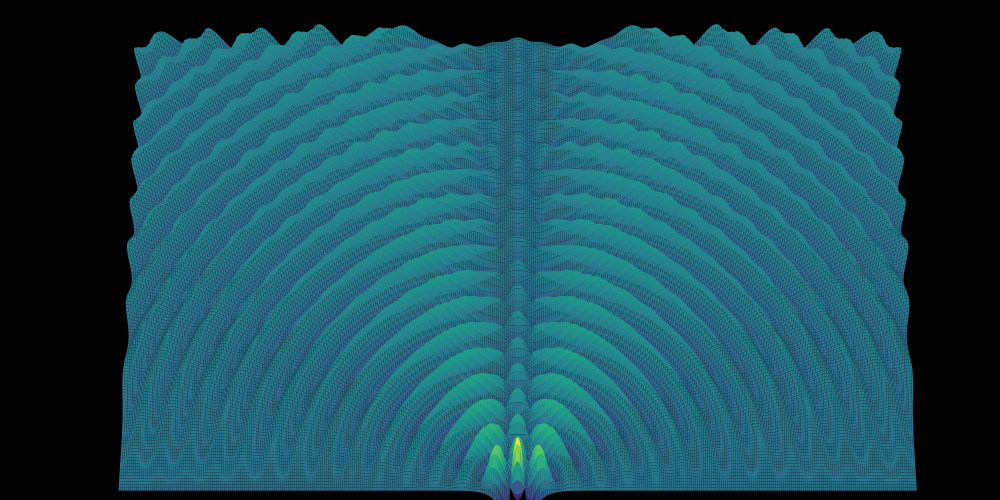

In [13]:
A.plot_field_2d(Psci.propagate, surface=True, xs=np.linspace(-20,20,1200), colorbar=False, zoom=3,
                azim=-90, elev=75, 
                zmax=24, zref=480,
                rstride=3, cstride=3,
                
               )

# Working!?

Seems to be now approaching right solution.  I really didn't think adding in the guided mode alone would do it, but it appears to be doing it!

## Some caveats

It fixed the input function that was a Gaussian, but the guided mode pretty much looks like a gaussian anyway.  It doesn't fully fix the piecewise quadratic case.

# Note weird issues: (fixed, had random cell resetting it, probably from earlier)

Running cells too fast causes scipy quad to take a long time, and then somehow my f0 function in P gets reassigned to the gaussian.  Very strange.  If I run them slow this doesn't occur.

In [14]:
diff = lambda x: Psci.f0(x) - alpha * Fs4(x)
half = lambda x:  Psci.slice_propagate(x)

NameError: name 'alpha' is not defined

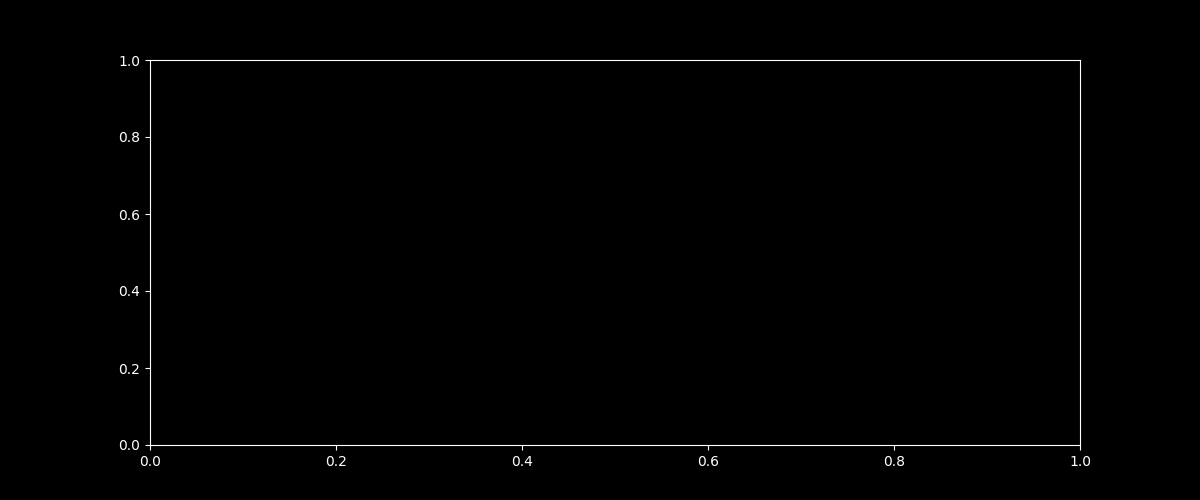

In [15]:
A.plot_field_1d(diff, xs=xs, part='real')
ax = plt.gca()
A.add_1d_plot(ax, quadratic_piecewise, xs=xs)
A.add_1d_plot(ax, half, xs=xs, linestyle='--')

(-0.1, 0.15)

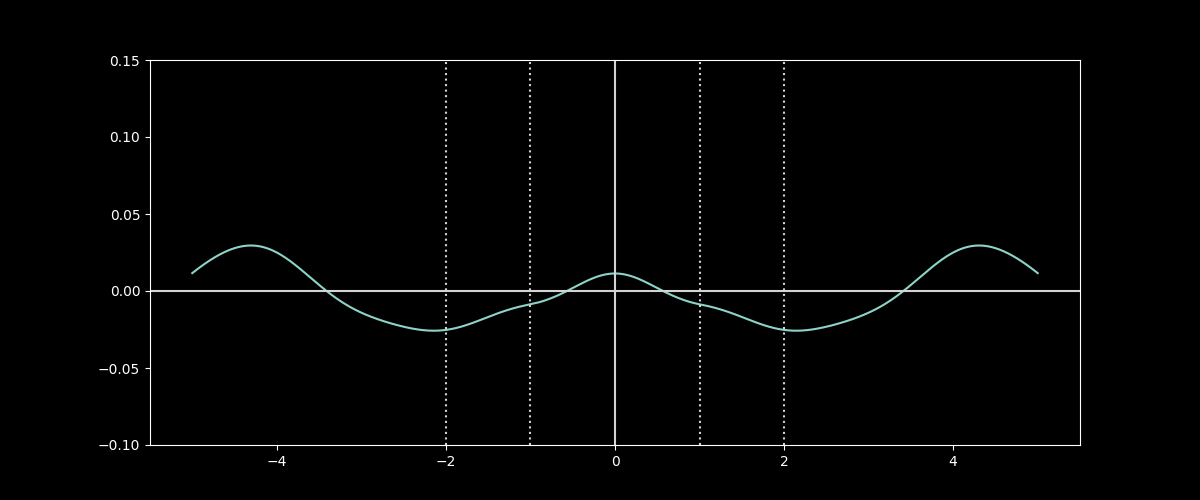

In [131]:
plt.close('all')
slice = lambda x: Psci.slice_propagate(x, 10)
A.plot_field_1d(slice, xs=xs)
ax = plt.gca()
ax.set_ylim(-.1,.15)